In [1]:
# Imports
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Visualize Data Sample

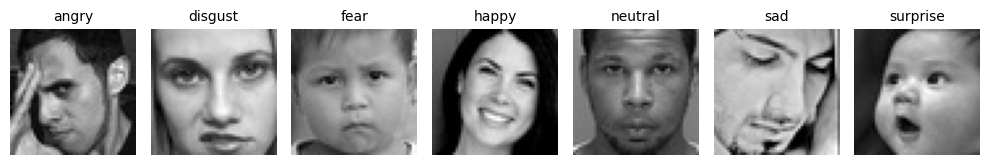

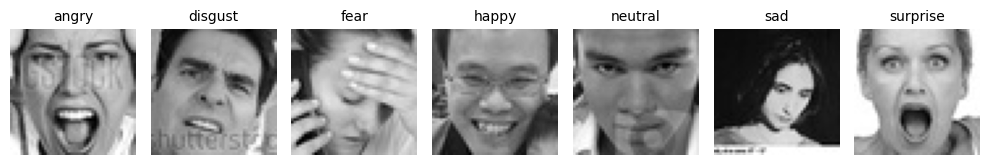

In [2]:
# Define directories
train_data_dir = 'fer2013/train'
val_data_dir = 'fer2013/val'

# Function to display an image from each folder
def display_images_from_folder(directory):
    # Get all subfolders in the directory
    subfolders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    cols = len(subfolders)
    plt.figure(figsize=(10, 10))
    
    index = 1
    for folder in subfolders:
        folder_path = os.path.join(directory, folder)
        # Get a list of all images in the folder
        image_files = os.listdir(folder_path)
        image_path = os.path.join(folder_path, random.choice(image_files))
        
        # Open the image using PIL and convert to grayscale
        img = Image.open(image_path).convert('L')
        img = np.array(img)  # Convert the image to a NumPy array
        
        # Plot the image
        plt.subplot(1, cols, index)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(folder, fontsize=10)
        plt.axis('off')
        index += 1

    # Display the figure with all the images
    plt.tight_layout() # Adjust spacing between subplots
    plt.show()

# Display images from each directory
display_images_from_folder(train_data_dir)
display_images_from_folder(val_data_dir)


### Data Loading and Pre Processing

In [3]:
BATCH_SIZE = 64
INPUT_SIZE = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=None, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=None)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

def preprocess_fer2013(image):
    # Convert grayscale image to RGB by repeating the single channel across 3 channels
    image = np.repeat(image[..., np.newaxis], 3, axis=-1)  # Correctly expand to (224, 224, 3)
    return image

preprocessing_function = preprocess_fer2013

Found 28474 images belonging to 7 classes.
Found 7022 images belonging to 7 classes.


### Load Base Model for Transfer Learning

In [ ]:
# https://github.com/av-savchenko/face-emotion-recognition/blob/main/models/pretrained_faces/age_gender_tf2_224_deep-03-0.13-0.97.h5

base_model = load_model('face_detection.h5')
base_model.summary()
net_description = 'mobilenet_face' # checkpoints 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Adjusting the Model

In [5]:
# Initial Parameters Setup
N_CLASS=val_generator.num_classes
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

7 28474 7022


In [6]:
# Mapping Class Indices to Class Labels
class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [7]:
# Calculating Class Weights (balance the classes that are underrepresented)
(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, idx_to_class, val_generator.class_indices)

[3995  436 4097 7214 4965 4596 3171] {0: 1.8057571964956194, 1: 16.545871559633028, 2: 1.7608005857944837, 3: 1.0, 4: 1.4529707955689828, 5: 1.5696257615317666, 6: 2.2749921160517186} {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'} {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:

# Adds a custom classification layer to predict emotions.
layer_name='feats'
#layer_name='global_average_pooling2d_1'
#layer_name='fc7/relu'
layer_out=base_model.get_layer(layer_name)
x=layer_out.output

emotion_preds = Dense(N_CLASS, activation='softmax', name='emotion_preds')(x)
model=Model(base_model.input,emotion_preds)
start_epoch=0

# Freez the base model
base_model.trainable=False
for l in base_model.layers:
    l.trainable=False
    
# Compiling the Model
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

#Callbacks
mc = ModelCheckpoint(net_description+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy',patience=3)

FIRST_EPOCHS=3

print(model.input_shape)


(None, 224, 224, 3)


In [9]:
# Start training
hist1=model.fit(
    train_generator, 
    steps_per_epoch=nb_train_samples//BATCH_SIZE, 
    epochs=FIRST_EPOCHS, verbose=1, 
    initial_epoch=0, 
    callbacks=[mc, es], 
    validation_data=val_generator, 
    validation_steps=nb_validation_samples // BATCH_SIZE,
    class_weight=class_weights
    )

Epoch 1/3
444/444 [==============================] - ETA: 0s - loss: 2.3271 - accuracy: 0.5262
Epoch 1: val_accuracy improved from -inf to 0.57626, saving model to mobilenet_face.h5
444/444 [==============================] - 33s 62ms/step - loss: 2.3271 - accuracy: 0.5262 - val_loss: 1.1582 - val_accuracy: 0.5763
Epoch 2/3
443/444 [============================>.] - ETA: 0s - loss: 2.0697 - accuracy: 0.5725
Epoch 2: val_accuracy improved from 0.57626 to 0.58486, saving model to mobilenet_face.h5
444/444 [==============================] - 27s 61ms/step - loss: 2.0686 - accuracy: 0.5727 - val_loss: 1.1375 - val_accuracy: 0.5849
Epoch 3/3
443/444 [============================>.] - ETA: 0s - loss: 2.0285 - accuracy: 0.5838
Epoch 3: val_accuracy improved from 0.58486 to 0.58974, saving model to mobilenet_face.h5
444/444 [==============================] - 27s 61ms/step - loss: 2.0276 - accuracy: 0.5839 - val_loss: 1.1261 - val_accuracy: 0.5897


### Unfreeze the Last Layers 

In [ ]:
start_epoch=len(hist1.history['loss'])
# Unfreeze the last few layers (top 4 layers)
for layer in base_model.layers[-4:]:
    layer.trainable = True
    
model.load_weights(net_description+'.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

SECOND_EPOCHS=start_epoch+17
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#es=EarlyStopping(monitor='val_accuracy',patience=2 )

hist2=model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE, 
    epochs=SECOND_EPOCHS, verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=val_generator, 
    validation_steps=val_generator.samples // BATCH_SIZE, 
    callbacks=[mc],class_weight=class_weights
    )

Epoch 4/20


c:\Users\daves\anaconda3\envs\tf_py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


444/444 [==============================] - ETA: 0s - loss: 1.7665 - accuracy: 0.6303
Epoch 4: val_accuracy improved from -inf to 0.64521, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 79s 171ms/step - loss: 1.7665 - accuracy: 0.6303 - val_loss: 0.9742 - val_accuracy: 0.6452
Epoch 5/20
444/444 [==============================] - ETA: 0s - loss: 1.5369 - accuracy: 0.6685
Epoch 5: val_accuracy improved from 0.64521 to 0.66872, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 75s 169ms/step - loss: 1.5369 - accuracy: 0.6685 - val_loss: 0.9180 - val_accuracy: 0.6687
Epoch 6/20
444/444 [==============================] - ETA: 0s - loss: 1.4017 - accuracy: 0.6885
Epoch 6: val_accuracy improved from 0.66872 to 0.68019, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 75s 168ms/step - loss: 1.4017 - accuracy: 0.6885 - val_loss: 0.8947 - val_accuracy: 0.6802
Epoch 7/20
444/444 [=========================

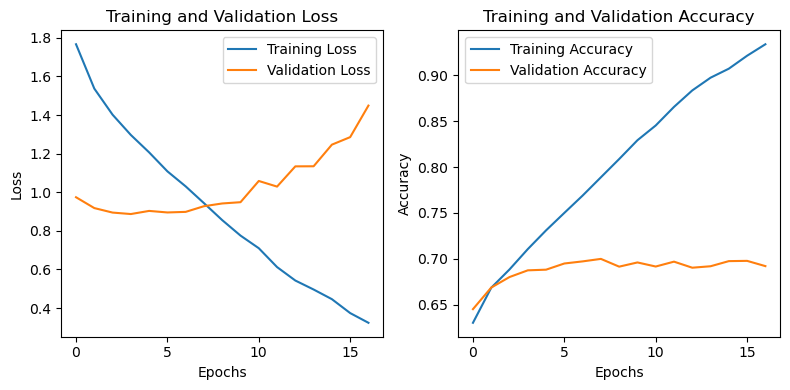

In [16]:
# Extracting training and validation loss and accuracy from history
history = hist2.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Fulley Unfreezed Train 

In [ ]:
start_epoch=len(hist2.history['loss'])
for l in base_model.layers:
    l.trainable=True
    
model.load_weights(net_description+'.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\daves\anaconda3\envs\tf_py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:

SECOND_EPOCHS=start_epoch+10
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#es=EarlyStopping(monitor='val_accuracy',patience=2 )

hist3=model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE, 
    epochs=SECOND_EPOCHS, verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=val_generator, 
    validation_steps=val_generator.samples // BATCH_SIZE, 
    callbacks=[mc],class_weight=class_weights
    )

Epoch 18/27
444/444 [==============================] - ETA: 0s - loss: 1.8238 - accuracy: 0.6208
Epoch 18: val_accuracy improved from -inf to 0.63876, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 79s 172ms/step - loss: 1.8238 - accuracy: 0.6208 - val_loss: 0.9844 - val_accuracy: 0.6388
Epoch 19/27
444/444 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.6685
Epoch 19: val_accuracy improved from 0.63876 to 0.65783, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 76s 170ms/step - loss: 1.5385 - accuracy: 0.6685 - val_loss: 0.9507 - val_accuracy: 0.6578
Epoch 20/27
444/444 [==============================] - ETA: 0s - loss: 1.3974 - accuracy: 0.6931
Epoch 20: val_accuracy improved from 0.65783 to 0.66829, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 75s 170ms/step - loss: 1.3974 - accuracy: 0.6931 - val_loss: 0.9238 - val_accuracy: 0.6683
Epoch 21/27
444/444 [=======

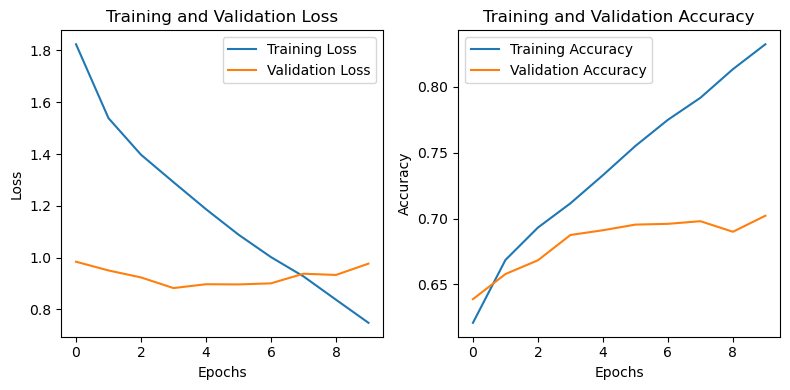

In [21]:
# Extracting training and validation loss and accuracy from history
history = hist3.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

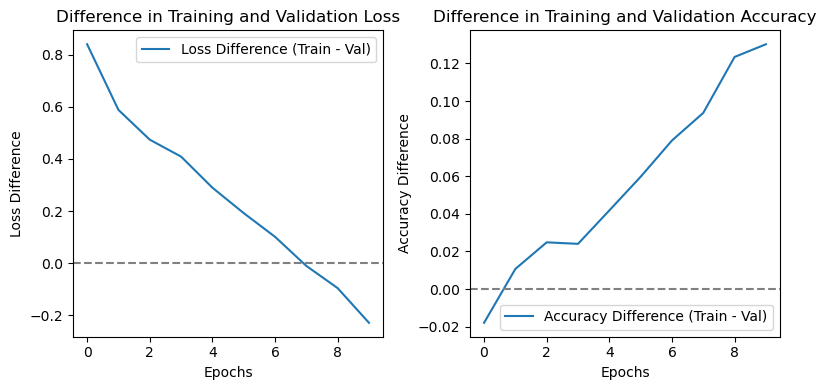

In [82]:
plt.figure(figsize=(8, 4))

# Difference between training and validation loss
plt.subplot(1, 2, 1)
loss_diff = np.array(history['loss']) - np.array(history['val_loss'])
plt.plot(loss_diff, label='Loss Difference (Train - Val)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()

# Difference between training and validation accuracy
plt.subplot(1, 2, 2)
acc_diff = np.array(history['accuracy']) - np.array(history['val_accuracy'])
plt.plot(acc_diff, label='Accuracy Difference (Train - Val)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference')
plt.legend()

plt.tight_layout()
plt.show()
